# Following Karpathy's tutorial:

## https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1

## 1. Derivatives

### Definition of derivative
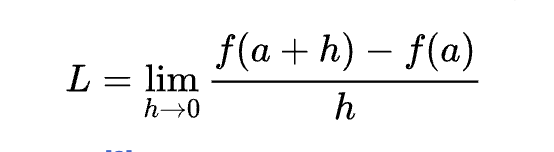

- slope of a function at a given point
-   how sensitive a function is to change in x values


In [1]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Parabola
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

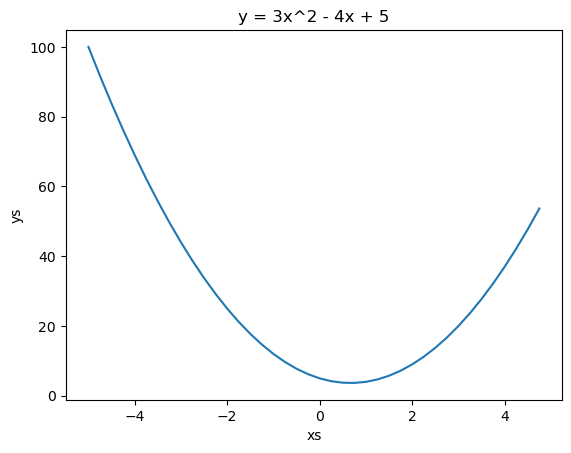

In [4]:
# range of x values from -5 to 5 with a step of 0.25
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)
plt.title("y = 3x^2 - 4x + 5")
plt.xlabel("xs")
plt.ylabel('ys')
plt.show()

In [5]:

h = 0.00001
x = 2/3 # parabolas minimum has a slope of 0
(f(x + h) - f(x)) / h # --> numerical approximation; rise / run

3.0000002482211127e-05

In [6]:
# finding derivatives of d in respect to a,b,c
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
# in respect to a
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
d2 = (a+h)*b + c

print('d1', d1)
print('d2', d2) # less than 4 so slope is negative
print('slope', (d2-d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [8]:
# in respect to b
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
d2 = a*(b+h) + c

print('d1', d1)
print('d2', d2) # will be greater than 4 so slope is positive
print('slope', (d2-d1)/h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [9]:
# in respect to c
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
d2 = a*b + (c+h)

print('d1', d1)
print('d2', d2) # higher by same amount changed meaning slope is 1
print('slope', (d2-d1)/h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


## Value Object and Micrograd

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # children tuple for efficiency
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) 
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward  
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()


In [28]:
# visualization code from tutorial

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rabkdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label=f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f}}}", shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## Backpropagation Manually

### Chain Rule
- `dz / dx` = `dz / dy` * `dy / dx`

- product of rates of change

- `Intuition`: If car travels `2x` as fast as a bicycle and the bicycle is `4x` as fast as a man, then the car is `2 x 4 = 8x` faster than the man

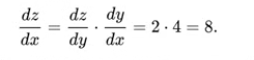
### **Most Important**
`dL / dd` = `-2.0`

`dd / de` = `1.0` 

### **WANT**: 

`dL / de`

### **KNOW**:

`dL / dd`

`dd / de`

### By chain rule:

`dL / de` = `(dL / dd)` * `(dd / de)`

`dL / de` = `(-2.0)` * `(1.0)`

`dL / de` = `-2.0`

### For **dL / da**

`dL / da` = `dL / de` * `de / da`

`dL / da` = `-2.0` * `-3.0`

`dL / da` = `6.0`

### For **dL / db**

`dL / db` = `dL / de` * `de / db`

`dL / db` = `-2.0` * `2.0`

`dL / db` = `-4.0`

## Backpropagation through a neuron

In [95]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813725870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - tanh(n)^2
n.grad = 1 - (o.data)**2 # 0.5
# derivative flows for addition
b.grad = 0.5
x1w1x2w2.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5
x2.grad = 0.5
w2.grad = 0.0
x1.grad = -1.5
w1.grad = 1.0


In [122]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813725870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
# base case of 1
o.grad = 1.0

# topological order
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

# apply _backward on everything
for node in reversed(topo):
    node._backward()

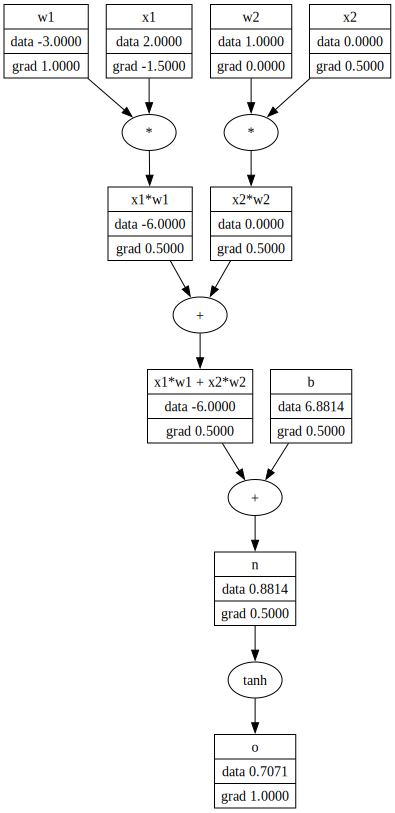

In [124]:
o.backward()
draw_dot(o)

In [ ]:
f